# VAE Analysis

## The previous Model and it's shortcomings. 
#### First let's load the model and plot the 5000 examples and 4 red points + 1 extra red point, from 03_02_autoencoder_analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn

from models.Autoencoder import Autoencoder
from torchvision import datasets, transforms
from scipy.stats import norm

In [2]:
test_ds = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

device = t.device('cuda') if t.cuda.is_available() else 'cpu'
prev_model = Autoencoder(test_ds[0][0][None], in_c=1, enc_out_c=[32, 64, 64, 64],
                    enc_ks=[3, 3, 3, 3], enc_pads=[1, 1, 0, 1], enc_strides=[1, 2, 2, 1],
                    dec_out_c=[64, 64, 32, 1], dec_ks=[3, 3, 3, 3], dec_strides=[1, 2, 2, 1],
                    dec_pads=[1, 0, 1, 1], dec_op_pads=[0, 1, 1, 0], z_dim=2)
prev_model.cuda(device)
prev_model.load_state_dict(t.load('models/state_dicts/03_01.pth'))
prev_model.eval()

t.set_grad_enabled(False)
encoder = prev_model.enc_conv_layers
decoder = prev_model.dec_conv_layers

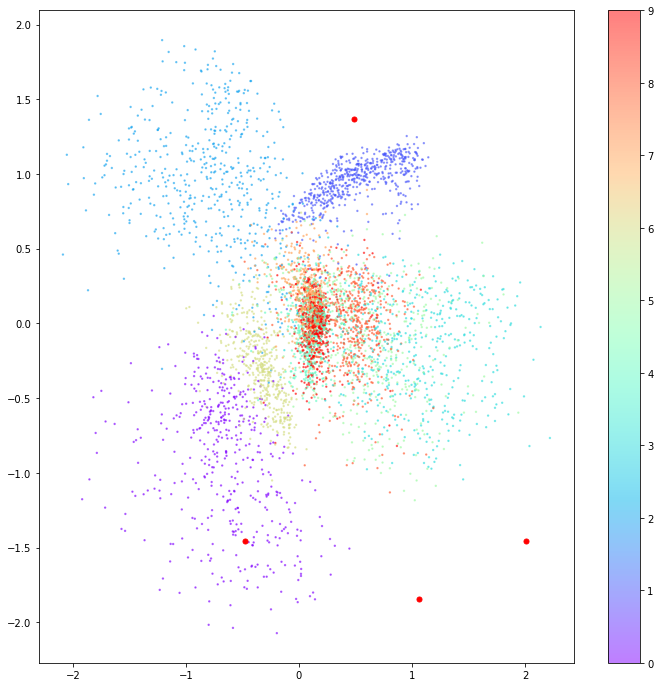

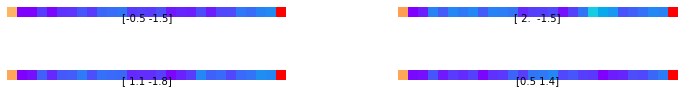

In [7]:
test_dl = t.utils.data.DataLoader(dataset=test_ds, batch_size=5000, shuffle=False, drop_last=True)

figsize = 12
np.random.seed(42)

examples = next(iter(test_dl))
x, y = examples[0], examples[1]
z_points = encoder(x.to(device)).cpu()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=y, alpha=0.5, s=2)
plt.colorbar()

grid_size = 2
grid_depth = 2

zx_min, zx_max, zy_min, zy_max = min(z_points[:, 0]), max(z_points[:, 0]), min(z_points[:, 1]), max(z_points[:, 1])
x = np.random.uniform(zx_min, zx_max, size = grid_size * grid_depth)
y = np.random.uniform(zy_min, zy_max, size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = decoder(t.from_numpy(z_grid).float().to(device)).cpu()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=25)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)    
    ax.imshow(reconst[i, :,:,0], cmap = 'rainbow')

[-0.7 -1.5]	     [ 1.3 -1.5]	     [ 0.5 -1.9]	     [0.1 1.4]	     

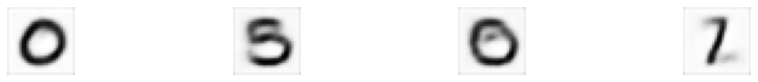

In [8]:
z_points = t.tensor([[-.7, -1.5], [1.3, -1.5], [.5, -1.9], [0.1, 1.4]])
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t     ')
    
for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


In [9]:
zx_min, zx_max, zy_min, zy_max

(tensor(-2.0872), tensor(2.2191), tensor(-2.0729), tensor(1.8961))

## Now we ask the question, why did [0.5, -1.9], the 7 look off?
### First as discussed, [.5, -1.9] is an outlier, from clusters within our zx_min, zx_max, zy_min and zy_max bounds.
### The underlying issue is that, the model is not as confident as it could be when picking points that are in a discontinous latent space because it wasn't trained to pick out points from there and decode properly. Let's test this theory again with plotting decoded spaces, truly close to the bounds. 
现在我们问一个问题，为什么[0.5，-1.9]，7看起来不像?
首先，如前所述，[。5， -1.9]是一个异常值，它来自我们的zx_min、zx_max、zy_min和zy_max边界内的集群。
潜在的问题是，当在一个不连续的潜在空间中挑选点时，模型并没有像它可能的那样自信，因为它没有训练从那里挑选点并正确解码。让我们用绘制真正接近边界的解码空间来再次测试这个理论。

[-2.0871878 -2.072938 ]	[-2.0871878  2.219089 ]	[ 2.219089 -2.072938]	[2.219089  1.8961482]	

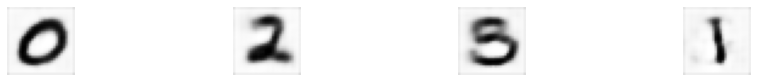

In [12]:
z_points = t.tensor([[zx_min, zy_min], [zx_min, zx_max], [zx_max, zy_min], [zx_max, zy_max]])
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t')
    
for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


#### Above you can see the numbers have smears of black, and the first two are not really clear what number it's to be

## So now, coming back to the problem again. You can see from the rainbow colored cluster graph that it isn't densely packed and there are a lot of discontinuous spaces. The outlier itself isn't the issue, as you'll see that even addressing this issue, you will have outliers, but what you don't want is discontinuous spaces between clusters.
现在，再次回到这个问题。你可以从彩虹色的簇图中看到，它并不是密集的，而且有很多不连续的空间。离群值本身不是问题，因为您将看到，即使解决了这个问题，也会有离群值，但您不希望集群之间有间断的空间。


### Essentially our Neural network didn't have enough say in how to make a properly dense, but distinct clusters(w.r.t. a continous scale) for our number images. 

### To address this, first, we added the Lambda layer from VariationalAutoencoder.py that helps us sample similar points for similar images when trained. The two vectors, mu and log_var, gives a multivariate normal distribution around some point in the latent space, which is a mapping that randomly distributes some sample spaces for the encodings, close to the mu(mean) vs just a straight 1-vector(two points) mapping as we had before. Now remember a net's job is to reduce loss, however if our loss doesn't tell it to try to map similar images to similar distributions of point spaces, it can't disperse and cluster well around those points. So how do we tell that?
本质上，我们的神经网络没有足够的发言权，在如何形成一个适当密集，但独特的簇(w.r.t。一个连续的尺度)为我们的数字图像。
为了解决这个问题，首先，我们从variationalautocoder .py中添加了Lambda层，它帮助我们在训练时为相似的图像采样相似的点。这两个向量，mu和log_var，给出了一个围绕潜在空间中某个点的多元正态分布，这是一个为编码随机分布一些样本空间的映射，接近于mu(均值)和我们之前所拥有的一个直接的1-向量(两点)映射。记住，网络的作用是减少损失，然而，如果我们的损失没有告诉它尝试将相似的图像映射到相似的点空间分布，它就不能很好地分散和聚集在这些点周围。我们怎么知道呢?

### Well it turns out, we don't tell much of that, it's something the net figures out as training. However, we can actually augment it, as well as add another nice to have on the global latent space.

### We first add to our loss function, another loss(KL div) that makes it so that our Net has to be trained in a way to optimize the probability distribution params mu and log_var to resemble the target distributions. This by itself, will try to just cluster around the same center, but as you saw from the rainbow graph above, training a encoder and decoder just happens to try to encode similar things to a similar cluster. With that in mind, we now train with both KL div and the regular loss(can use BCE or MSE, but I found BCE works better. This trick(sigmoid scaling) is used a lot to train faster and better in other domains). This means that we will have a densly packed area in terms of the whole latent space, while maintaining well formed clusters within in, with the power of continuous ranges of encoding for similar images.
结果是，我们没有告诉太多，这是一些净额计算出来的训练。然而，我们实际上可以增加它，以及在全局潜在空间上添加另一个nice。
我们首先添加我们的损失函数，另一个损失(KL div)，使我们的网络必须以一种优化概率分布参数mu和log_var的方式进行训练，以类似于目标分布。它会试图围绕同一个中心聚类，
但正如你从上面的彩虹图中看到的，训练编码器和解码器只是碰巧试图将相似的东西编码成相似的簇。考虑到这一点，我们现在训练的KL div和常规损失(可以使用BCE或MSE，但我发现BCE（binary crossentropy ）更好。这种技巧(sigmoid缩放)被大量用于在其他领域更快更好地训练。这意味着我们将有一个密集的区域在整个潜在空间，同时保持良好的簇内，与连续范围的编码类似的图像的力量。

## Now, with Variational Auto Encoding

In [13]:
import torch as t
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from models.VariationalAutoencoder import VariationalAutoencoder
from torchvision import datasets, transforms


In [14]:
test_ds = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

device = t.device('cuda') if t.cuda.is_available() else 'cpu'
model = VariationalAutoencoder(test_ds[0][0][None], in_c=1, enc_out_c=[32, 64, 64, 64],
                    enc_ks=[3, 3, 3, 3], enc_pads=[1, 1, 0, 1], enc_strides=[1, 2, 2, 1],
                    dec_out_c=[64, 64, 32, 1], dec_ks=[3, 3, 3, 3], dec_strides=[1, 2, 2, 1],
                    dec_pads=[1, 0, 1, 1], dec_op_pads=[0, 1, 1, 0], z_dim=2)
model.cuda(device)
model.load_state_dict(t.load('models/state_dicts/03_03.pth'))
model.eval()

t.set_grad_enabled(False)
encoder = model.enc_conv_layers
decoder = model.dec_conv_layers

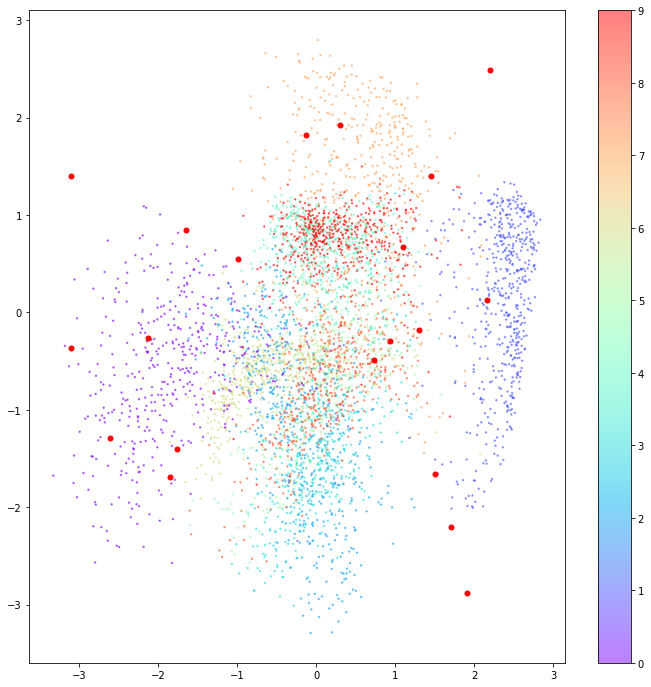

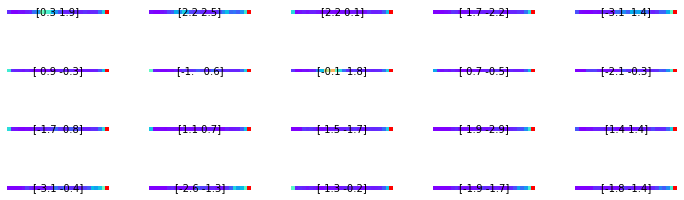

In [15]:
test_dl = t.utils.data.DataLoader(dataset=test_ds, batch_size=5000, shuffle=False, drop_last=True)

figsize = 12
np.random.seed(20)

examples = next(iter(test_dl))
x, y = examples[0], examples[1]
z_points = encoder(x.to(device))[0].cpu()

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], cmap='rainbow', c=y, alpha=0.5, s=2)
plt.colorbar()

grid_size = 5
grid_depth = 4

zx_min, zx_max, zy_min, zy_max = min(z_points[:, 0]), max(z_points[:, 0]), min(z_points[:, 1]), max(z_points[:, 1])
x = np.random.uniform(zx_min, zx_max, size = grid_size * grid_depth)
y = np.random.uniform(zy_min, zy_max, size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = decoder(t.from_numpy(z_grid).float().to(device)).cpu()

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=25)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size * grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=10, ha='center', transform=ax.transAxes)    
    ax.imshow(reconst[i, :,:,0], cmap = 'rainbow')

[0.29428008 1.9279789 ]	[2.2024953 2.4887905]	[2.1643844  0.12700675]	[ 1.6978244 -2.203218 ]	[-3.1096387  1.3962559]	[ 0.9330175  -0.29476255]	[-0.9967324  0.5503607]	[-0.1348446  1.817661 ]	[ 0.7246425  -0.48549607]	[-2.1359968  -0.26093233]	[-1.652345   0.8434326]	[1.0985061 0.6692303]	[ 1.4954422 -1.6554221]	[ 1.9104158 -2.8814967]	[1.4476187 1.4035172]	[-3.1048634  -0.36411986]	[-2.611576  -1.2877823]	[ 1.2999077 -0.1836389]	[-1.8563564 -1.686863 ]	[-1.760276  -1.4015522]	

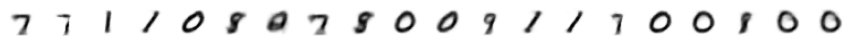

In [23]:
z_points = t.tensor(z_grid).float()
bs = len(z_points)
reconst_imgs = decoder(z_points.to(device))

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for z_point in z_points:
    print(z_point.numpy(), end='\t')
    
for i in range(bs):
    img = reconst_imgs[i].cpu().squeeze()
    ax = fig.add_subplot(2, bs, i + bs + 1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


In [18]:
zx_min, zx_max, zy_min, zy_max

(tensor(-3.3309), tensor(2.8330), tensor(-3.2912), tensor(2.7944))

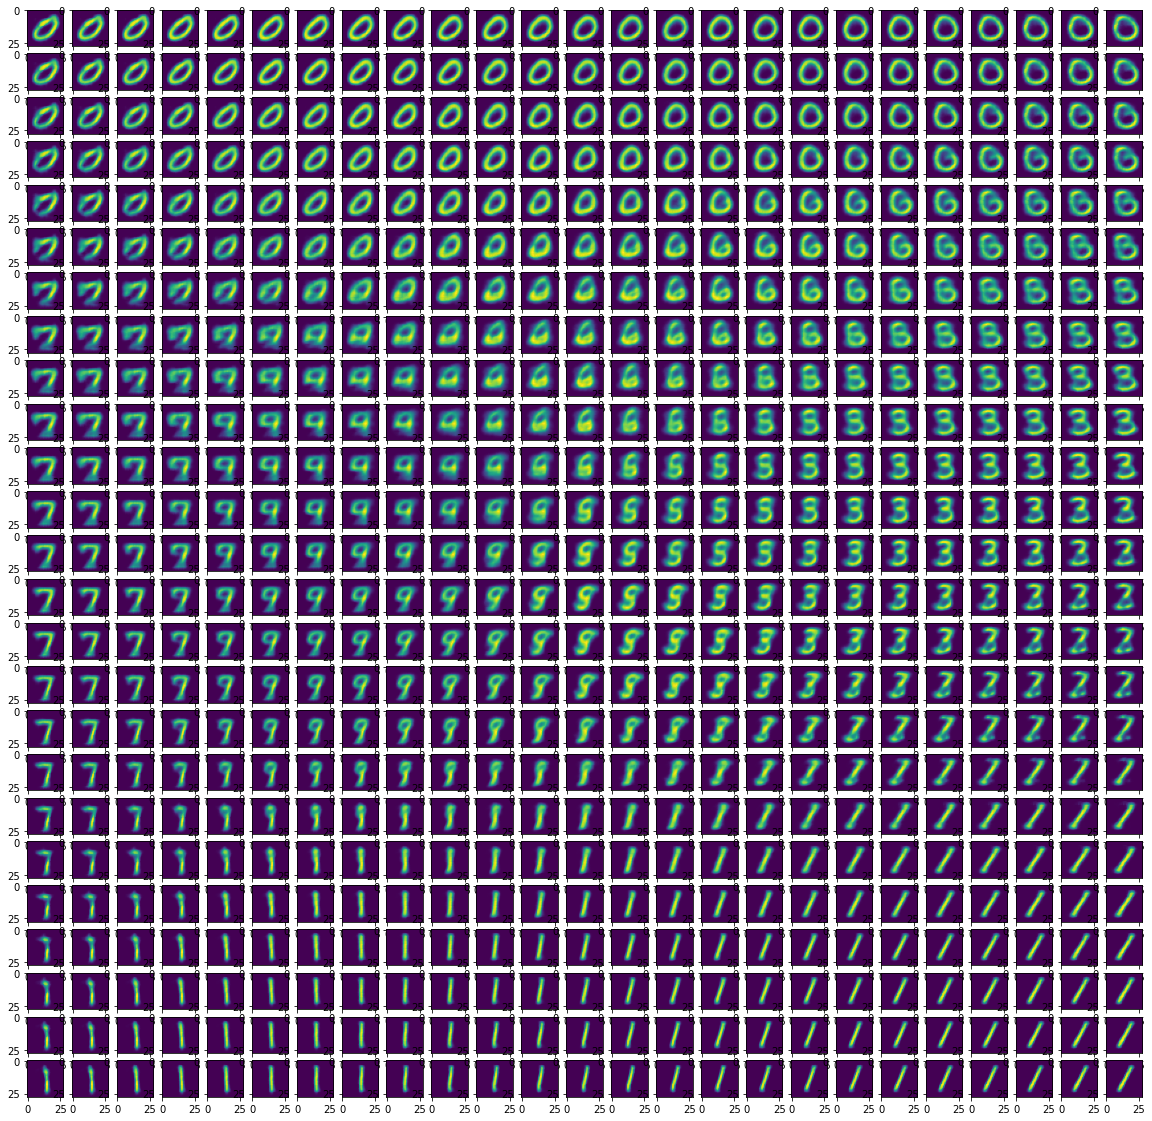

In [24]:
row, col = 25, 25
z_points = t.tensor([[a,b] for a in np.linspace(zx_min + 1 , zx_max, row) for b in np.linspace(zy_max - 1, zy_min + 1, col)])

bs = len(z_points)
with t.no_grad():
    reconst_imgs = decoder(z_points.float().to(device))

f, axarr = plt.subplots(row, col, figsize=(20,20))
i = 0
for r in range(row):
    for c in range(col):
        axarr[r, c].imshow(reconst_imgs[i].cpu().squeeze())
        i += 1

In [31]:
reconst_imgs.shape

torch.Size([625, 1, 28, 28])

In [32]:
reconst_imgs.device

device(type='cuda', index=0)